<a href="https://colab.research.google.com/github/TheBuilderHero/Deep_Learning_Road_Mapping/blob/main/Final_Project_Task_Start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import needed Libraries

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download and decompress Data

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thebuilderherokota","key":"705cf075e6b380effd0f2494d5e39123"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
#! kaggle datasets list
!kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [00:35<00:00, 122MB/s]
100% 3.79G/3.79G [00:35<00:00, 115MB/s]


In [9]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip

In [10]:
!ls -l

total 3980160
-rw-r--r-- 1 root root         46 Nov 10  2020 class_dict.csv
-rw-r--r-- 1 root root 4074676823 Nov 10  2020 deepglobe-road-extraction-dataset.zip
-rw-r--r-- 1 root root         74 Apr 25 03:25 kaggle.json
-rw-r--r-- 1 root root     434416 Nov 10  2020 metadata.csv
drwxr-xr-x 1 root root       4096 Apr 23 13:23 sample_data
drwxr-xr-x 2 root root      36864 Apr 25 03:26 test
drwxr-xr-x 2 root root     466944 Apr 25 03:26 train
drwxr-xr-x 2 root root      45056 Apr 25 03:26 valid


## Get min size information associated with picture data

This is not really needed since we know the data is of size 1024 x 1024 but still kept it since it also provides the number of items.

In [11]:
from PIL import Image
filenames = []
sizes = []
index=1

# This is my path
paths = ["test", "valid", "train"]

# dirs=directories
for path in paths:
  for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.jpg' in f:
            filenames.append(f)
            filename = root + "/" + f
            sizes.append([Image.open(filename, 'r').size,index])
            index += 1


print(sizes)
print(max(sizes))
print(min(sizes))

# Define the target size
value = min(sizes)
print(value[0])
target_size = value[0]  # Specify the new width and height

[[(1024, 1024), 1], [(1024, 1024), 2], [(1024, 1024), 3], [(1024, 1024), 4], [(1024, 1024), 5], [(1024, 1024), 6], [(1024, 1024), 7], [(1024, 1024), 8], [(1024, 1024), 9], [(1024, 1024), 10], [(1024, 1024), 11], [(1024, 1024), 12], [(1024, 1024), 13], [(1024, 1024), 14], [(1024, 1024), 15], [(1024, 1024), 16], [(1024, 1024), 17], [(1024, 1024), 18], [(1024, 1024), 19], [(1024, 1024), 20], [(1024, 1024), 21], [(1024, 1024), 22], [(1024, 1024), 23], [(1024, 1024), 24], [(1024, 1024), 25], [(1024, 1024), 26], [(1024, 1024), 27], [(1024, 1024), 28], [(1024, 1024), 29], [(1024, 1024), 30], [(1024, 1024), 31], [(1024, 1024), 32], [(1024, 1024), 33], [(1024, 1024), 34], [(1024, 1024), 35], [(1024, 1024), 36], [(1024, 1024), 37], [(1024, 1024), 38], [(1024, 1024), 39], [(1024, 1024), 40], [(1024, 1024), 41], [(1024, 1024), 42], [(1024, 1024), 43], [(1024, 1024), 44], [(1024, 1024), 45], [(1024, 1024), 46], [(1024, 1024), 47], [(1024, 1024), 48], [(1024, 1024), 49], [(1024, 1024), 50], [(1024, 

## Load image data and Rescale pictures to smallest picture size

In [12]:
#!pip uninstall keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-ymh_i7sl
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-ymh_i7sl
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43609 sha256=f9a8a37e707c61d17c561c389faa98e5ef505e1ce68afbb0219a955013b44393
  Stored in directory: /tmp/pip-ephem-wheel-cache-10vri2rj/wheels/72/0b/c7/3f6b26f2d789c712867e02502e1f1b740091f8615f32a9f870
Successfully built Keras-Preprocessing


In [13]:
# this loads gets all the file names for both the pictures and their masks and puts them into a dataframe.
metadata_df = pd.read_csv(os.path.join("./", 'metadata.csv'))
class_df = pd.read_csv(os.path.join("./", 'class_dict.csv'))
metadata_train_df = metadata_df[metadata_df["split"] == "train"]
metadata_test_df = metadata_df[metadata_df["split"] == "test"]

#remove the plit column now that it is not needed:
metadata_train_df.drop("split",inplace=True,axis=1)
metadata_test_df.drop("split",inplace=True,axis=1)

#test does not need the mask path since it is gonna generate them:
metadata_test_df.drop("mask_path",inplace=True,axis=1)

#fix indexing:
metadata_train_df = metadata_train_df.reset_index()
metadata_test_df = metadata_test_df.reset_index()

# get full path to the images
metadata_train_df['sat_image_path'] = metadata_train_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_train_df['mask_path'] = metadata_train_df['mask_path'].apply(lambda img_pth: os.path.join("./", img_pth))
metadata_test_df['sat_image_path'] = metadata_test_df['sat_image_path'].apply(lambda img_pth: os.path.join("./", img_pth))

<ipython-input-13-d3138a5cf9b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train_df.drop("split",inplace=True,axis=1)
<ipython-input-13-d3138a5cf9b2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("split",inplace=True,axis=1)
<ipython-input-13-d3138a5cf9b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_test_df.drop("mask_path",inplace=True,axis=1)


#### Shuffle and split data

In [14]:
metadata_train_df = metadata_train_df.sample(frac=1).reset_index(drop=True)

In [15]:
valid_df = metadata_train_df.sample(frac=0.2,random_state=42)
train_df = metadata_train_df.drop(valid_df.index)

#### Get class data

In [16]:
class_names = class_df["name"].tolist()

In [17]:
RGB_values = class_df[["r","g","b"]].values.tolist()

In [18]:
Class_Type = ['background', 'road']

In [19]:
# Makes the class values 0 and 1
Class_Indices = [class_names.index(cls.lower()) for cls in Class_Type]

In [20]:
Class_RGB_Values = np.array(RGB_values)[Class_Indices]
# Creates a matrix of class RGB values

## Image Loading and Processing

In [21]:
import cv2
import pandas as pd
import tensorflow as tf

data_size = [3000,256,256] # size of images reduced by factor of 4 and we are taking the first 3000 images.

reduced_data = train_df[0:data_size[0]].reset_index(drop=True)

sat_images = []
mask_images = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images.append(img)
    mask_images.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [22]:
reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

sat_images_valid = []
mask_images_valid = []

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.

    sat_images_valid.append(img)
    mask_images_valid.append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

In [23]:
print(sat_images[0])
#print(mask_images[0])

[[[0.34509804 0.3372549  0.25098039]
  [0.43921569 0.40392157 0.30980392]
  [0.43529412 0.38431373 0.27843137]
  ...
  [0.45882353 0.49803922 0.45490196]
  [0.50588235 0.54509804 0.50196078]
  [0.48627451 0.52941176 0.48235294]]

 [[0.41176471 0.40392157 0.3254902 ]
  [0.34509804 0.32941176 0.23921569]
  [0.44313725 0.39607843 0.29019608]
  ...
  [0.4745098  0.50588235 0.4627451 ]
  [0.47843137 0.51764706 0.47843137]
  [0.52941176 0.56078431 0.51764706]]

 [[0.49411765 0.48627451 0.41568627]
  [0.36078431 0.36078431 0.27843137]
  [0.39607843 0.36470588 0.26666667]
  ...
  [0.46666667 0.49803922 0.45882353]
  [0.45490196 0.49411765 0.45882353]
  [0.50980392 0.54117647 0.50588235]]

 ...

 [[0.28627451 0.29019608 0.23529412]
  [0.37254902 0.36862745 0.29411765]
  [0.44313725 0.41568627 0.31372549]
  ...
  [0.22745098 0.27058824 0.22352941]
  [0.2627451  0.30980392 0.2627451 ]
  [0.25490196 0.30196078 0.25490196]]

 [[0.43137255 0.43137255 0.38431373]
  [0.35294118 0.34901961 0.29411765]


### Get some Augmented data

In [24]:
import random
def augment_data(sat_images,mask_images):
    augmented_sat_images = []
    augmented_mask_images = []
    for img, mask in zip(sat_images,mask_images):

      #randomly augment them over the x axis (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.flip(img,1))
          augmented_mask_images.append(cv2.flip(mask,1))

      #randomly augment them over the y axis (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.flip(img,0))
          augmented_mask_images.append(cv2.flip(mask,0))
        #A flag to specify how to flip the array; 0 means flipping around the x-axis and positive value (for example, 1) means flipping around y-axis. Negative value (for example, -1) means flipping around both axes. Return Value: It returns an image.
      #randomly augment them over the x and y axis (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.flip(img,-1))
          augmented_mask_images.append(cv2.flip(mask,-1))
      #randomly augement them by rotating them 180 degrees (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.rotate(img,cv2.ROTATE_180))
          augmented_mask_images.append(cv2.rotate(mask,cv2.ROTATE_180))
      #randomly augement them by rotating them 90 degrees (10%)
        if random.uniform(0,100) < 10:
          augmented_sat_images.append(cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE))
          augmented_mask_images.append(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE))
      #zoom into image by 10%
        if random.uniform(0,100) < 10:
          aug_img = cv2.resize(img, (230, 230))
          aug_mask = cv2.resize(mask, (230, 230))
          aug_img = cv2.resize(aug_img, (256, 256))
          aug_mask = cv2.resize(aug_mask, (256, 256))

          augmented_sat_images.append(aug_img)
          augmented_mask_images.append(aug_mask)

        #add all images to the array itself.
        augmented_sat_images.append(img)
        augmented_mask_images.append(mask)


    return augmented_sat_images,augmented_mask_images

#Add augmented images into the data:
sat_images,mask_images = augment_data(sat_images,mask_images)


### Getting some random samples of the data

Image shape: 4741, Mask shape: 4741


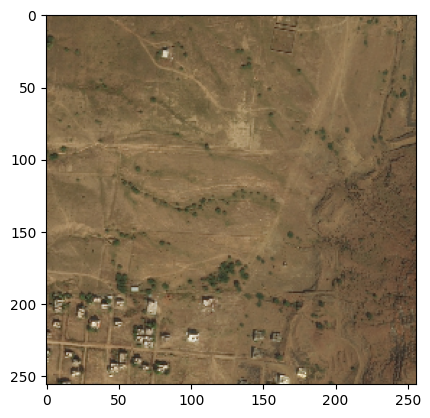

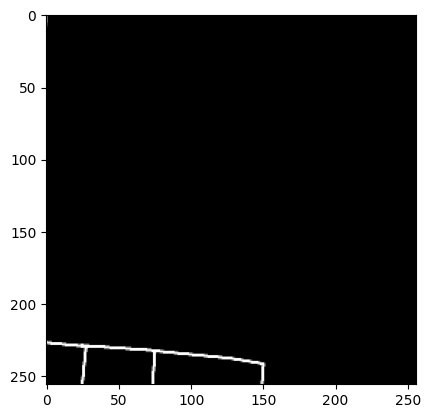

Image shape: 4741, Mask shape: 4741


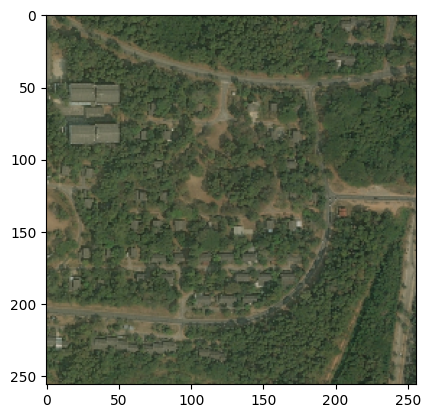

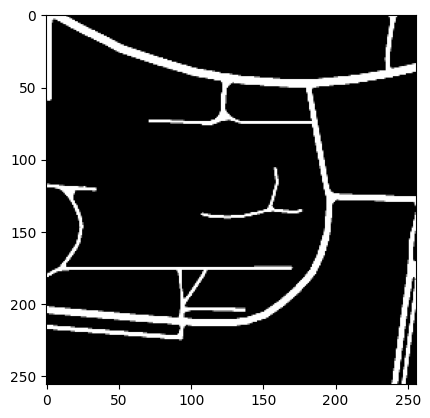

Image shape: 4741, Mask shape: 4741


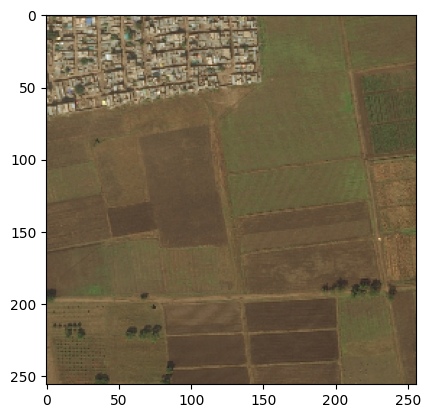

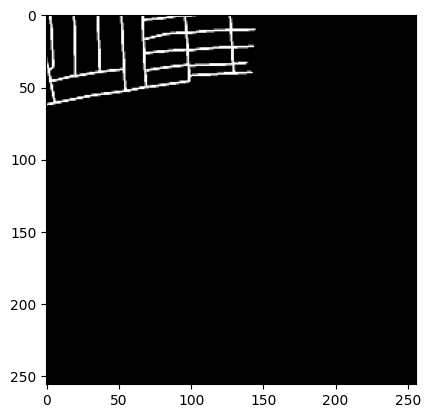

Image shape: 4741, Mask shape: 4741


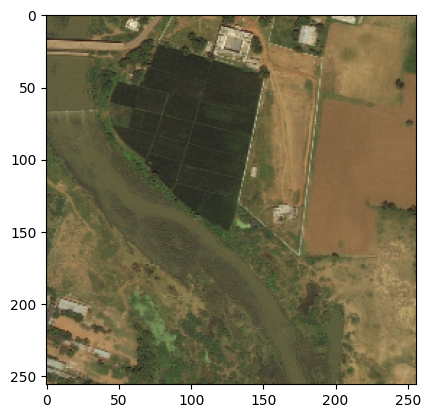

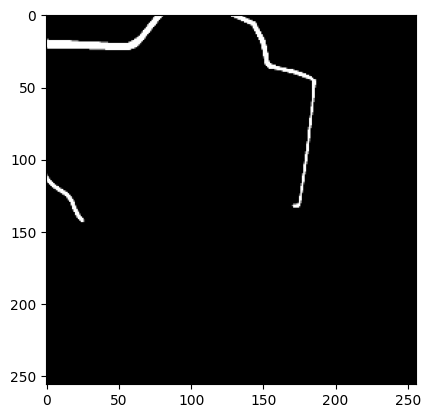

Image shape: 4741, Mask shape: 4741


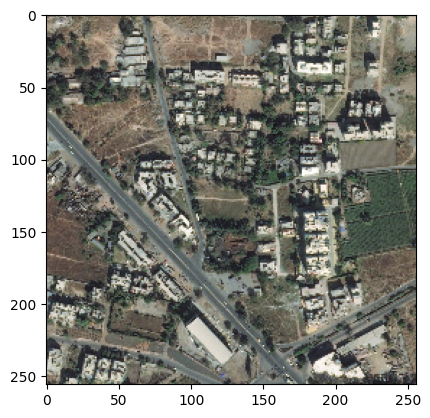

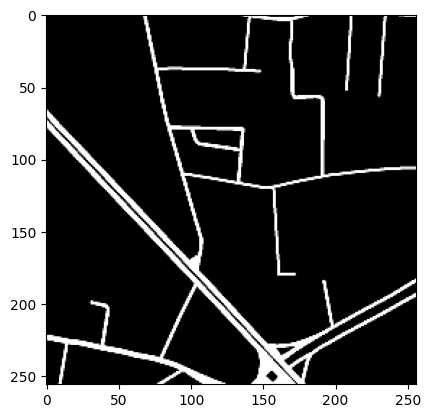

In [25]:
import random
for i in range(5):
  # Setup the dataset # Note that the class_rgb_values is being set to the RGB values of the input classes values.
  random_idx = random.randint(0, len(sat_images)-1)
  #image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
  print(f"Image shape: {len(sat_images)}, Mask shape: {len(mask_images)}")
  import matplotlib.pyplot as plt
  plt.imshow(sat_images[random_idx])
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = mask_images[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

  #plt.imshow(mask)
  #plt.show()

## Build the model

In [26]:
model = Sequential()
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape = (data_size[1],data_size[2],3), padding='same' ))
print(model.output_shape)
print(model.input_shape)
#model.add( MaxPool2D(3, 3) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' , padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 128, ( 5, 5 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
#model.add( MaxPool2D(2, 2) )


model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 7, 7 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))

#duplicated for complexity
model.add( Conv2D( 128, ( 7, 7 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001) ))
model.add(BatchNormalization())
#model.add( MaxPool2D(3, 3) )
model.add(Dropout(0.10))


model.add( Conv2D( 64, ( 5, 5 ), activation = 'relu' , padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
model.add(BatchNormalization())


#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
#model.add( MaxPool2D(2, 2) )
model.add(Dropout(0.10))
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', padding='same', kernel_regularizer =tf.keras.regularizers.l2( l=0.001)) )
#model.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', padding='same' ) )
#model.add( Flatten() )
#model.add( Dense( 512, activation = 'relu' ) )
#model.add( Dense( 256, activation = 'sigmoid' ) )


model.add( Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding='same' ) )

(None, 256, 256, 32)
(None, 256, 256, 3)


In [27]:
from keras.callbacks import ModelCheckpoint

# Define the filepath for saving the weights
filepath = "model_weights.h5"

# Load the saved weights into the model
#model.load_weights("model_weights.h5")

# Define a ModelCheckpoint callback to save the weights
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

## Compile the model and overfit it to the Data

In [28]:
sat_images = np.array(sat_images)
mask_images = np.array(mask_images)

sat_images_reshaped = sat_images.reshape((-1, 256, 256, 3))
mask_images_reshaped = mask_images.reshape((-1, 256, 256, 1))

In [29]:
model.compile( optimizer = 'adam', loss= 'categorical_crossentropy', metrics = [ 'accuracy' ])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     204928    
                                                        

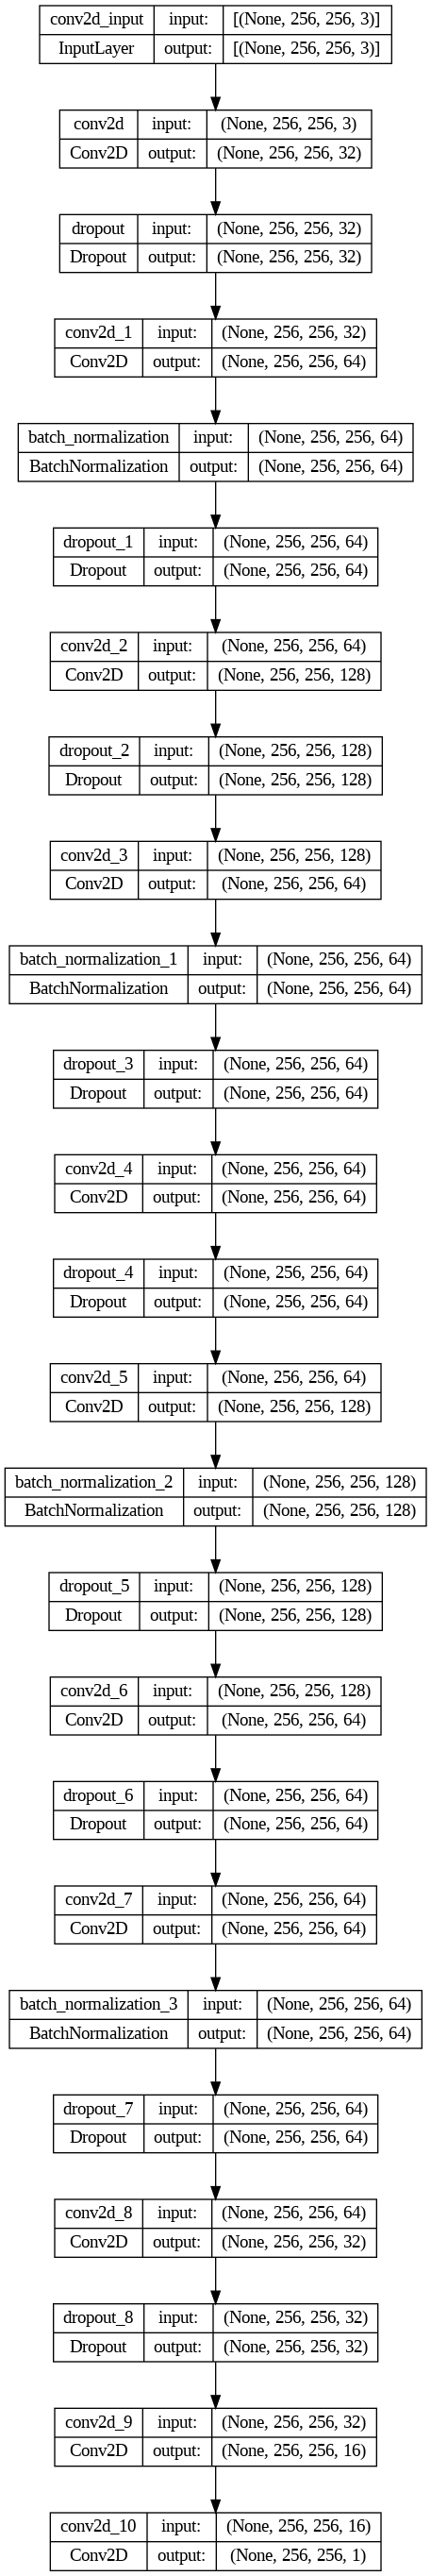

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
# Load the saved weights into the model
#model.load_weights("model_weights.h5")

In [32]:
#train_generator_one_hot.element_spec
history = model.fit(sat_images,mask_images, batch_size=2, epochs = 5, callbacks=[checkpoint], validation_split=0.2)

Epoch 1/5
1896/1896 [==============================] - 208s 101ms/step - loss: 52.2338 - accuracy: 0.9071 - val_loss: 46.9152 - val_accuracy: 0.9560
Epoch 2/5
   1/1896 [..............................] - ETA: 2:41 - loss: 150.3614 - accuracy: 0.8864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1896/1896 [==============================] - 189s 100ms/step - loss: 48.9962 - accuracy: 0.9547 - val_loss: 44.8637 - val_accuracy: 0.9580
Epoch 3/5
1896/1896 [==============================] - 188s 99ms/step - loss: 48.1047 - accuracy: 0.9564 - val_loss: 44.0069 - val_accuracy: 0.9606
Epoch 4/5
1896/1896 [==============================] - 188s 99ms/step - loss: 47.4295 - accuracy: 0.9574 - val_loss: 44.7508 - val_accuracy: 0.9604
Epoch 5/5
1896/1896 [==============================] - 187s 99ms/step - loss: 47.1157 - accuracy: 0.9582 - val_loss: 43.1878 - val_accuracy: 0.9616


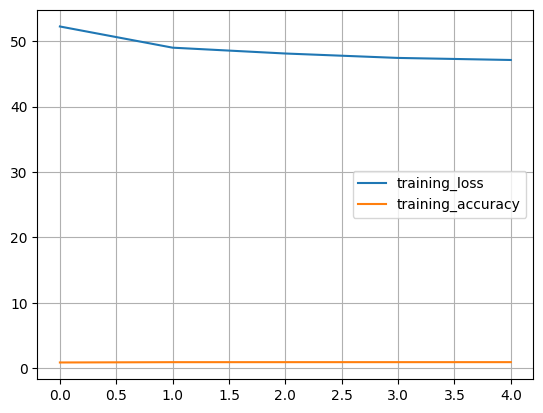

In [33]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.plot(history.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

### Get 4 metrics

In [34]:
# Load the saved weights into the model
model.load_weights("model_weights.h5")

In [35]:
valid_df.head()

index  image_id          sat_image_path                mask_path
239     961    239988  ./train/239988_sat.jpg  ./train/239988_mask.png
1119   5088    831619  ./train/831619_sat.jpg  ./train/831619_mask.png
2215   3878    653446  ./train/653446_sat.jpg  ./train/653446_mask.png
2500   5960    957715  ./train/957715_sat.jpg  ./train/957715_mask.png
5783   5307    861243  ./train/861243_sat.jpg  ./train/861243_mask.png

In [61]:
import numpy as np

I_stats = [] # empty list of sat maps
Y_stats = [] # empty list of true labels
P_stats = [] # empty list of predictions
P_base_stats = [] # empty list of all zeros arrays which should help us find out model's baseline

# used for displaying example images
I = [] # empty list of sat maps
Y = [] # empty list of true labels
P = [] # empty list of predictions


data_size = [len(valid_df),256,256]

reduced_data = valid_df[0:data_size[0]].reset_index(drop=True)

# Read into the program each image:
for img, mask in zip(reduced_data.sat_image_path, reduced_data.mask_path):
    img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(data_size[1],data_size[2]))
    img = img/255.

    img = img.reshape((-1, 256, 256, 3))

    mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask,(data_size[1],data_size[2]))
    mask = mask/255.


    pred = model.predict(img)  # Make predictions for the batch

    #print(mask.shape)
    #print(pred.shape)

    temp_mask = mask[:,:,0].reshape((-1, 256, 256, 1))

    I.extend(img)
    Y.extend(temp_mask)# this is because its a binary mask and img is present in channel 0
    P.extend(pred)

    mask = mask[:,:,0].reshape((256 * 256))
    pred_baseline = np.zeros(mask.shape)
    pred = pred.reshape((256 * 256))

    #acc = np.sum(mask == pred) / np.size(mask)
    #pre = np.sum(mask * pred) / np.sum(pred)
    #rec = np.sum(mask * pred) / np.sum(mask)
    #f1 = 2 * pre * rec / (pre + rec)


    I_stats.extend(img)
    Y_stats.extend([mask])# this is because its a binary mask and img is present in channel 0
    P_base_stats.extend([pred_baseline])
    P_stats.extend([pred])
    #break;

#print("Accuracy:", acc)
#print("Precision:", pre)
#print("Recall:", rec)
#print("F1-score:", f1)

1/1 [==============================] - 0s 23ms/step


In [62]:
print(mask.max())
print(pred.max())

1.0
0.9300566


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_stats = np.array(Y_stats)
P_stats = np.array(P_stats)
P_base_stats = np.array(P_base_stats)

print("Y_stats shape:", Y_stats.shape)
print("P_stats shape:", P_stats.shape)

# Convert data types to float32
Y_stats = Y_stats.astype(np.int64)
P_stats = P_stats.astype(np.int64)

print("Y_stats data type:", Y_stats.dtype)
print("P_stats data type:", P_stats.dtype)

# Calculate evaluation metrics
# For multi-class segmentation
accuracy = accuracy_score(Y_stats.flatten(), np.round(P_stats).flatten())
precision = precision_score(Y_stats.flatten(), np.round(P_stats).flatten(), average='weighted')
recall = recall_score(Y_stats.flatten(), np.round(P_stats).flatten(), average='weighted')
f1 = f1_score(Y_stats.flatten(), np.round(P_stats).flatten(), average='weighted')

# Calculate Base evaluation metrics
# For multi-class segmentation
base_accuracy = accuracy_score(Y_stats.flatten(), np.round(P_base_stats).flatten())
base_precision = precision_score(Y_stats.flatten(), np.round(P_base_stats).flatten(), average='weighted')
base_recall = recall_score(Y_stats.flatten(), np.round(P_base_stats).flatten(), average='weighted')
base_f1 = f1_score(Y_stats.flatten(), np.round(P_base_stats).flatten(), average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("Base Accuracy:", base_accuracy)
print("Base Precision:", base_precision)
print("Base Recall:", base_recall)
print("Base F1-score:", base_f1)

print("Improvement Accuracy:", accuracy - base_accuracy)
print("Improvement Precision:", precision - base_precision)
print("Improvement Recall:", recall - base_recall)
print("Improvement F1-score:", f1 - base_f1)

#print(Y_stats)
#print(P_stats)


Y_stats shape: (1245, 65536)
P_stats shape: (1245, 65536)
Y_stats data type: int64
P_stats data type: int64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9605314813943273
Precision: 0.922620726749581
Recall: 0.9605314813943273
F1-score: 0.9411945031287275
Base Accuracy: 0.9605314813943273
Base Precision: 0.922620726749581
Base Recall: 0.9605314813943273
Base F1-score: 0.9411945031287275
Improvement Accuracy: 0.0
Improvement Precision: 0.0
Improvement Recall: 0.0
Improvement F1-score: 0.0


Image shape: 1245, Mask shape: 1245


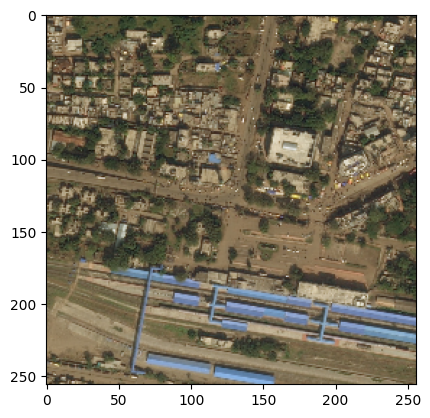

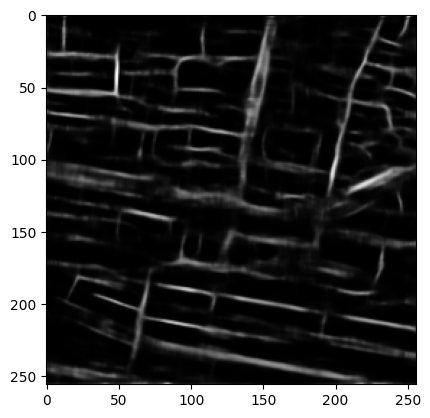

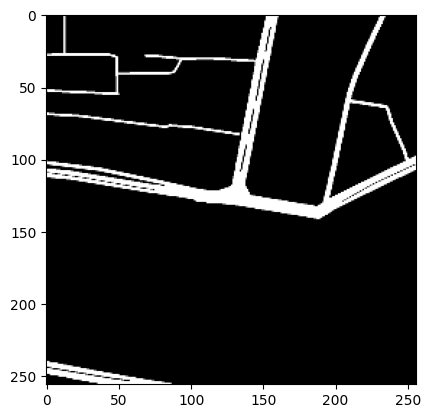

Image shape: 1245, Mask shape: 1245


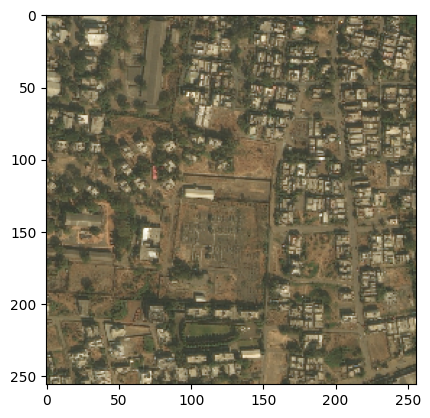

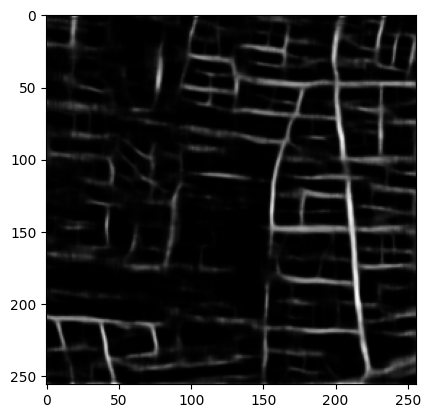

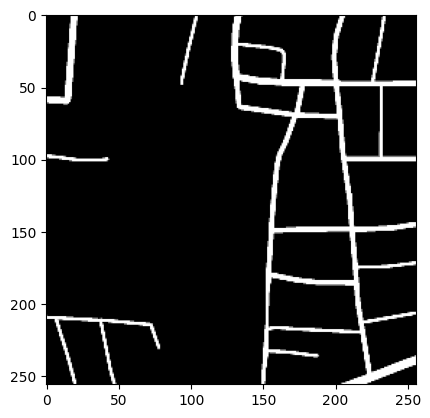

Image shape: 1245, Mask shape: 1245


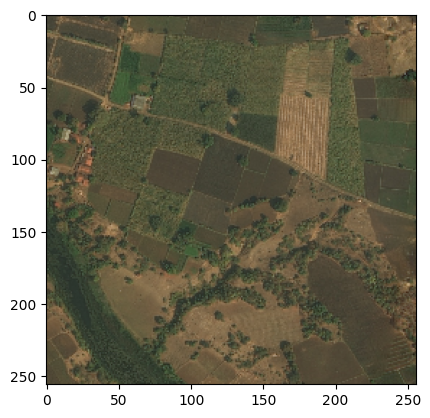

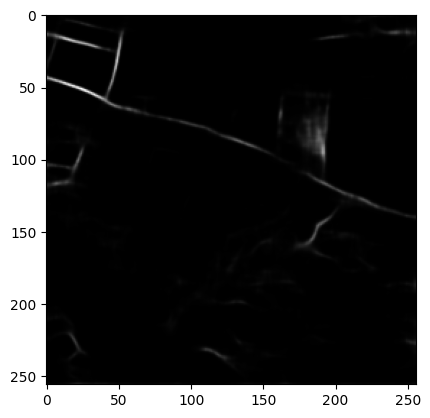

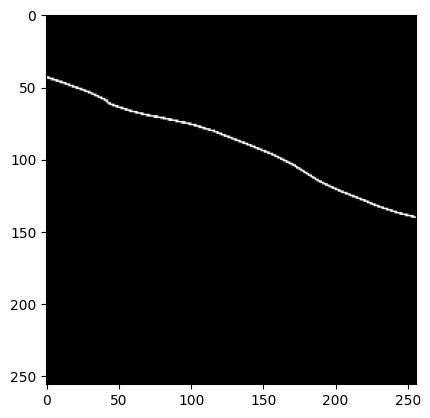

Image shape: 1245, Mask shape: 1245


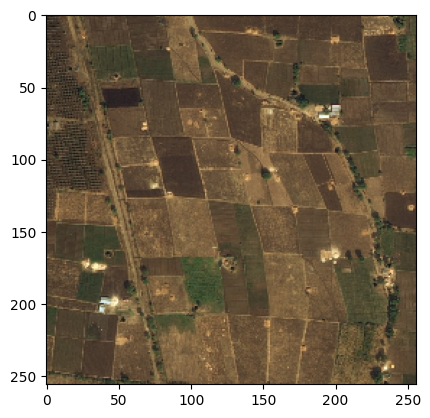

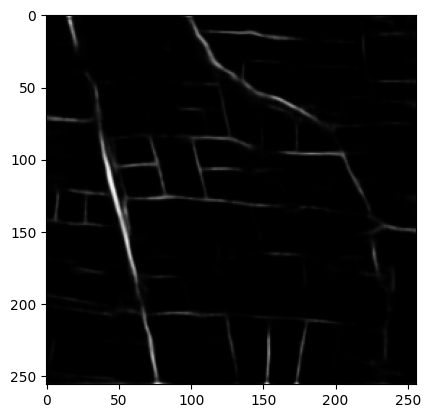

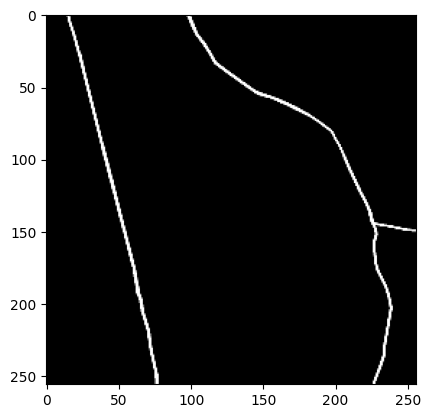

Image shape: 1245, Mask shape: 1245


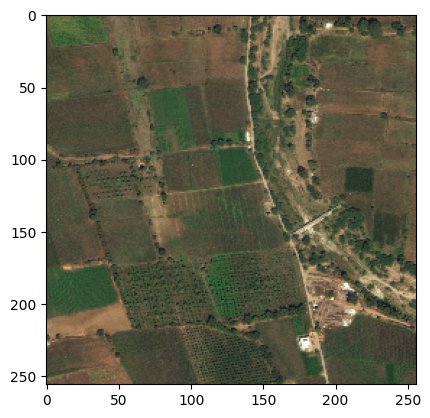

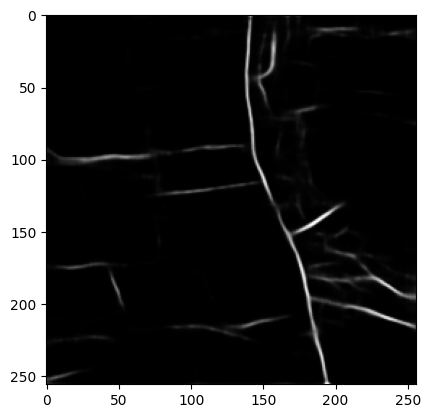

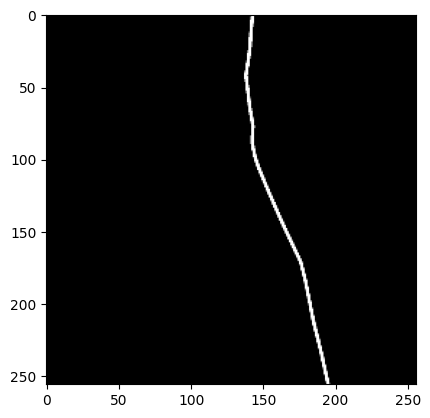

In [66]:
for i in range(5):
  random_idx = random.randint(0, len(I)-1)
  #image, mask = reduced_data[random_idx].sat_image_path, reduced_data[random_idx].mask_path # get some random sample
  print(f"Image shape: {len(I)}, Mask shape: {len(P)}")
  import matplotlib.pyplot as plt
  plt.imshow(I[random_idx])
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = P[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

  # Convert multi-channel mask to single-channel mask just for the sake of showing it.
  mask_single_channel = Y[random_idx]
  plt.imshow(mask_single_channel, cmap='gray')
  plt.show()

## Convert to HTML this notebook

In [ ]:
#%%shell
#jupyter nbconvert --to html /content/TestProject_OverFitting_AllData.ipynb